# Neural Network

Neural Networks are a machine learning model that learns the optimal parameters to approximate complex functions.

GitHub Repo: https://github.com/gavinkhung/neural-network

Import the libraries

In [1]:
import numpy as np

%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from celluloid import Camera
import scienceplots
from IPython.display import Image

np.random.seed(0)
plt.style.use(["science", "no-latex"])

## Training Dataset

The neural network will learn the parameters to fit a Hyperbolic Paraboloid.

$
\begin{align*}
z &= \frac{y^2}{b^2} - \frac{x^2}{a^2}
\end{align*}
$

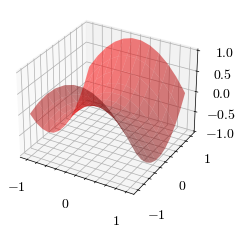

In [2]:
def generate_function(dims):
    a = 1
    b = 1

    # Hyperbolic Paraboloid
    x = np.linspace(-1, 1, dims)
    y = np.linspace(-1, 1, dims)
    X, Y = np.meshgrid(x, y)
    Z = (Y**2 / b**2) - (X**2 / a**2)

    X_t = X.flatten()
    Y_t = Y.flatten()
    Z_t = Z.flatten()
    X_t = X_t.reshape((len(X_t), 1))
    Y_t = Y_t.reshape((len(Y_t), 1))
    Z_t = Z_t.reshape((len(Z_t), 1))
    features = np.stack((X_t, Y_t), axis=1)
    labels = Z_t.reshape((len(Z_t), 1, 1))

    return X, Y, Z, features, labels


dims = 12
X, Y, Z, features, labels = generate_function(dims)

# Visualize the Hyperbolic Paraboloid
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X, Y, Z, color="red", alpha=0.5)

## Loss Function
The loss function is needed to evaluate the performance of the model and to update the weights accordingly. The optimizaton process of the neural network training will find the weights and biases to minimie the loss.

### Mean Squared Error
Quadratic loss functions, like mean squared error, are used for regression tasks, like this example.

$ J = \frac{1}{n} \sum_{i=1}^{n}(y_{i}-\hat{y})^2 $

In [3]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

### Mean Squared Error Gradient
In order to perform backpropagation to update the weights, we need to calculate the gradient of the loss function.

$
\begin{align*}
J^{\prime} &= \frac{\partial}{\partial \hat{y}} [ \frac{1}{n} \sum_{i=1}^{n}(y_{i}-\hat{y})^2 ] \\
&= \frac{1}{n} \sum_{i=1}^{n}\frac{\partial}{\partial \hat{y}} [ (y_{i}-\hat{y})^2 ] \\
&= \frac{2}{n} \sum_{i=1}^{n} (y_{i}-\hat{y}) \frac{\partial}{\partial \hat{y}}[y_{i}-\hat{y}] \\
&= \frac{2}{n} \sum_{i=1}^{n} (y_{i}-\hat{y}) (-1) \\
&= \frac{2}{n} \sum_{i=1}^{n}(\hat{y}-y_{i})
\end{align*}
$

In [4]:
def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

## Neural Network Layer

We will implement a feedforward neural network, which contains many layers. Each layer at a very high applies a linear transformation to the input data to create the output data, which is often in a different dimension than the input data. Then, all of the values in the output are run through a function, known as an activation function. 

Recall from Linear Algebra that an input column vector $x$ in $\mathbb{R}^n$ can be transformed into another dimension $\mathbb{R}^m$ by multipying it with a matrix of size $m \times n$. Finally we can add a bias term to this linear transformation to shift the transformed data up or down.

As a result, each layer stores a weight matrix and a bias vector to apply the linear transformation.

In [5]:
from abc import ABC, abstractmethod


class Layer(ABC):
    def __init__(self):
        self.input = None
        self.output = None
        self.weights = None
        self.bias = None

    @abstractmethod
    def forward(self, input):
        pass

    @abstractmethod
    def backward(self, output_gradient, optimizer):
        pass

## Forward Propagation

This the process of transforming our input data into the predictions from our feedforward neural network. The input data is passed through every layer of the network. Below is a visualization of the 3 layer network we will implement.

![Neural Network](plot/nn.svg)

Each neuron in a layer is a weighted sum of its inputs plus a bias term. Finally, an activation function is applied on each neuron in the layer. We will have a class to represent a fully-connected layer and another class to represent an activation function.

The computation for each neuron in a layer being a weighted sum of the products between the inputs and the layer's weights plus a bias term is the same as a matrix multiplication between the weight matrix and the input data added with a bias vector.

Thus, the foward propagation of a fully connected layer can be written as:

$
\begin{align*}
Z &= W X + B \\
A &= g(Z)
\end{align*}
$

Where:
- $W$ is the weight matrix for the layer
- $X$ is the input data
- $B$ is a bias vector
- $g$ is the activation function

## Our Network's Forward Propagation

We will implement a 3-layer fully-connected neural network with a Tanh activation function after each layer. These transformations can be written as these matrix multiplications:

$
\begin{align*}
Z_1 &= W_1 X + B_1 \\
A_1 &= tanh(Z_1) \\
\\
Z_2 &= W_2 A_1 + B_2 \\
A_2 &= tanh(Z_2) \\
\\
Z_3 &= W_3 A_2 + B_3 \\
\hat{y} &= A_3 = tanh(Z_3)
\end{align*}
$

## Backpropagation

Backpropagation is the process of updating all of the weights and biases in a neural network using the chain rule and gradient descent.

Given $J$ is our loss function, our goal:

$
\begin{align*}
W_1 &= W_1 - lr * \frac{\partial J}{\partial W_1} \\
B_1 &= B_1 - lr * \frac{\partial J}{\partial B_1} \\
W_2 &= W_2 - lr * \frac{\partial J}{\partial W_2} \\
B_2 &= B_2 - lr * \frac{\partial J}{\partial B_2} \\
W_3 &= W_3 - lr * \frac{\partial J}{\partial W_3} \\
B_3 &= B_3 - lr * \frac{\partial J}{\partial B_3} \\
\end{align*}
$

We need to use the chain rule to get the values for $\frac{\partial J}{\partial W_1}$, $\frac{\partial J}{\partial B_1}$, $\frac{\partial J}{\partial W_2}$, $\frac{\partial J}{\partial B_2}$, $\frac{\partial J}{\partial W_3}$, and $\frac{\partial J}{\partial B_3}$.

### Chain Rule for Backpropagation

Let's derive a general formula to update the weights and biases of a single fully-connected layer.

For the 3rd layer, for example, we need to find the loss with respect to $W_3$ and $B_3$, which are $\frac{\partial J}{\partial W_3}$, and $\frac{\partial J}{\partial B_3}$.

From the chain rule, we know the following:

$
\frac{\partial J}{\partial Z_3} = \frac{\partial J}{\partial A_3} \frac{\partial A_3}{\partial Z_2} 
$

Then to get the loss with respect to $W_3$ and $B_3$, we apply the chain rule again.

$
\frac{\partial J}{\partial W_3} = \frac{\partial J}{\partial Z_3} \frac{\partial Z_3}{\partial W_3} = \frac{\partial J}{\partial A_3} \frac{\partial A_3}{\partial Z_3} \frac{\partial Z_3}{\partial W_3}
$

$
\frac{\partial J}{\partial B_3} = \frac{\partial J}{\partial Z_3} \frac{\partial Z_3}{\partial B_3} = \frac{\partial J}{\partial A_3} \frac{\partial A_3}{\partial Z_3} \frac{\partial Z_3}{\partial B_3}
$

## Backpropagation for Weight Matrix W

Let's break each component down: $\frac{\partial J}{\partial W_3} = \frac{\partial J}{\partial A_3} \frac{\partial A_3}{\partial Z_3} \frac{\partial Z_3}{\partial W_3}$

$\frac{\partial J}{\partial A_3}$ is the gradient of the loss function, which is the gradient of the mean squared error function. Click [here for the derivation of the loss function](#mean-squared-error-gradient). In the general case for any layer, this is the gradient from the next layer (idx+1).

$\frac{\partial A_3}{\partial Z_3} = \frac{\partial}{\partial Z_3}[tanh(Z_3)] $ is the gradient of the activation function. Click [here for the derivation of the activation function](#tanh-activation-function-gradient).

$\frac{\partial Z_3}{\partial W_3} = \frac{\partial}{\partial W_3}[W_3 A_2 + B_3] = A_2$ is the original input to the layer, which is the output of the previous layer (idx-1).

As a result, to the gradient of the weight matrix of a fully-connected layer is the matrix multiplication products of the following:
1. The gradient from the next layer (idx+1)
2. The gradient of the activation function
3. The input from the previous layer (idx-1)

## Backpropagation for Bias Vector B

Let's break each component down: $\frac{\partial J}{\partial B_3} = \frac{\partial J}{\partial A_3} \frac{\partial A_3}{\partial Z_3} \frac{\partial Z_3}{\partial B_3}$

$\frac{\partial J}{\partial A_3}$ is the gradient of the loss function, which is the gradient of the mean squared error function. Click [here for the derivation of the loss function](#mean-squared-error-gradient). In the general case for any layer, this is the gradient from the next layer (idx+1).

$\frac{\partial A_3}{\partial Z_3}$ is the gradient of the activation function. Click [here for the derivation of the activation function](#tanh-activation-function-gradient).

$\frac{\partial Z_3}{\partial B_3} = \frac{\partial}{\partial B_3}[W_3 A_2 + B_3] = 1$ is 1, we can ignore this in the gradient computation.

As a result, to the gradient of the bias vector of a fully-connected layer is the matrix multiplication products of the following:
1. The gradient from the next layer (idx+1)
2. The gradient of the activation function

For more information, I recommend the follow resources:
- [Neural Network from Scratch](https://www.youtube.com/watch?v=pauPCy_s0Ok). I also watched this video to help write this Notebook.
- [The Most Important Algorithm in Machine Learning](https://www.youtube.com/watch?v=SmZmBKc7Lrs)

## Dense Layers

A dense layer is a fully connected layer. Let's use the equations derived in the forward and backwards propagation sections above to implement the `forward()` and `backward()` methods of our dense layer class.

In [6]:
class Dense(Layer):
    def __init__(self, input_neurons, output_neurons):
        # Random Values from Normal Distribution
        # self.weights = np.random.randn(output_neurons, input_neurons)
        # self.bias = np.random.randn(output_neurons, 1)

        # All Zeros
        # self.weights = np.zeros((output_neurons, input_neurons))
        # self.bias = np.zeros((output_neurons, 1))

        # Xavier Initialization Uniform Distribution
        limit = np.sqrt(6 / (input_neurons + output_neurons))
        self.weights = np.random.uniform(
            -limit, limit, size=(output_neurons, input_neurons)
        )
        self.bias = np.zeros((output_neurons, 1))

    def forward(self, input):
        self.input = input
        return np.matmul(self.weights, self.input) + self.bias

    def backward(self, output_gradient, optimizer):
        # Calculate gradients
        weights_gradient = np.matmul(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)

        # Update weights and biases
        self.weights, self.bias = optimizer.backward(
            self.weights, weights_gradient, self.bias, output_gradient
        )
        return input_gradient

## Activation Function

Activation functions are applied after the matrix multiplication to introduce nonlinearity into our neural networks. Choosing the correct activation function is essential for the neural network to learn general patterns of the training data. Most notably, the ReLU function is very useful when training very deep neural networks with many layers, as seen from the 2012 AlexNet paper, in order to prevent vanishing gradients, where the network fails to update its weights from super small gradients

In [7]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input_val):
        self.input = input_val
        return self.activation(self.input)

    def backward(self, output_gradient, optimizer):
        return np.multiply(output_gradient, self.activation_prime(self.input))

    def plot(self, x_min, x_max, points=25):
        x = np.linspace(x_min, x_max, points)
        y = self.activation(x)
        y_prime = self.activation_prime(y)

        fig, axes = plt.subplots(1, 2)
        axes[0].plot(x, y)
        axes[0].set_xlabel("X")
        axes[0].set_ylabel("Y")
        axes[0].set_title("F(X)")

        axes[1].plot(x, y_prime)
        axes[1].set_xlabel("X")
        axes[1].set_ylabel("Y")
        axes[1].set_title("F'(X)")

### Tanh Activation Function

We will use the Tanh activation function for our network:

$
\begin{align*}
\sigma(z) &= \frac{e^z-e^{-z}}{e^z+e^{-z}}
\end{align*}
$

### Tanh Activation Function Gradient

Since gradient descent relies on knowing the gradient of our activation function, let's derivate the gradient of the tanh function.

$
\begin{align*}
\sigma^\prime(z) &= \frac{\partial}{\partial z} [ \frac{e^z-e^{-z}}{e^z+e^{-z}} ] \\
&= \frac{(e^z+e^{-z})\frac{\partial}{\partial z}[e^z-e^{-z}] - (e^z-e^{-z})\frac{\partial}{\partial z}[e^z+e^{-z}]}{({e^z+e^{-z}})^2} \\
&= \frac{(e^z+e^{-z})(e^z+e^{-z}) - (e^z-e^{-z})(e^z-e^{-z})}{({e^z+e^{-z}})^2} \\
&= \frac{(e^z+e^{-z})^2 - (e^z-e^{-z})^2}{({e^z+e^{-z}})^2} \\
&= \frac{(e^z+e^{-z})^2}{({e^z+e^{-z}})^2} - \frac{(e^z-e^{-z})^2}{({e^z+e^{-z}})^2} \\
&= 1 - [\sigma(z)]^2
\end{align*}
$

Now that we have derived the gradient of the Tanh function, let's create the class for the Tanh activation function.

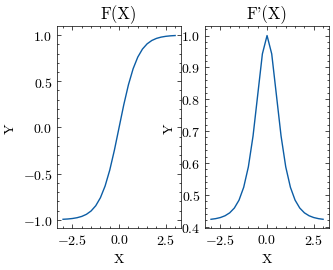

In [8]:
class Tanh(Activation):
    def __init__(self):
        tanh = lambda x: np.tanh(x)
        tanh_prime = lambda x: 1 - np.tanh(x) ** 2
        super().__init__(tanh, tanh_prime)


Tanh().plot(-3, 3)

## Optimizer

Our optimization algorithm will be Gradient Descent, allowing us to determine how to update the parameters in the next iteration.

$ X_{n+1} = X_n - lr * \frac{\partial}{\partial X} f(X_n)$.

Let's create a class that updates the weight matrix and the bias vector using the Gradient Descent equation. 

In [9]:
class GradientDescentOptimizier:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def backward(self, weights, weights_gradient, bias, output_gradient):
        weights -= self.learning_rate * weights_gradient
        bias -= self.learning_rate * output_gradient

        return weights, bias

## Graphing Functions

This Notebook will create many visualizations of the neural network during its training phase.

`create_scatter_and_3d_plot()` creates a 2 column graph for the Mean Squared Error graph on the left and a 3D graph on the right.

`create_3d_and_3d_plot()` creates a 2 column graph with two 3D graphs.

`plot_3d_predictions()` plots the neural network's current preditions and the expected output of the neural network.

`plot_layer_loss_landscape()` plots how close one layer's current weights are from the optimal weights by seeing how the total mean squared error changes if the weights were shifted a little.

In [10]:
import copy


def create_scatter_and_3d_plot():
    fig, ax = plt.subplots(1, 3, figsize=(16 / 9.0 * 4, 4 * 1))
    fig.suptitle("Neural Network Predictions")

    ax[0].set_xlabel("Epoch", fontweight="normal")
    ax[0].set_ylabel("Error", fontweight="normal")
    ax[0].set_title("Mean Squared Error")

    ax[1].axis("off")
    ax[2].axis("off")

    ax[2] = fig.add_subplot(1, 2, 2, projection="3d")
    ax[2].set_xlabel("X")
    ax[2].set_ylabel("Y")
    ax[2].set_zlabel("Z")
    ax[2].set_title("Function Approximation")
    ax[2].view_init(20, -35)
    ax[2].set_zlim(-1, 1)
    ax[2].axis("equal")

    camera = Camera(fig)
    return ax[0], ax[2], camera


def create_3d_and_3d_plot():
    fig, ax = plt.subplots(
        1, 2, figsize=(16 / 9.0 * 4, 4 * 1), subplot_kw={"projection": "3d"}
    )
    fig.suptitle("Neural Network Loss Landscape")

    ax[0].set_xlabel("W3_1")
    ax[0].set_ylabel("W3_2")
    ax[0].set_zlabel("MSE")
    ax[0].set_title("Mean Squared Error")
    ax[0].view_init(20, -35)
    ax[0].set_zlim(-1, 1)
    ax[0].axis("equal")

    ax[1].set_xlabel("X")
    ax[1].set_ylabel("Y")
    ax[1].set_zlabel("Z")
    ax[1].set_title("Function Approximation")
    ax[1].view_init(20, -35)
    ax[1].set_zlim(-1, 1)
    ax[1].axis("equal")

    camera = Camera(fig)
    return ax[0], ax[1], camera


def plot_3d_predictions(ax, X, Y, Z, predictions, dims):
    # Plot Neural Network Function Approximation
    # Ground truth
    ground_truth_legend = ax.plot_surface(
        X, Y, Z, color="red", alpha=0.5, label="Ground Truth"
    )

    # Neural Network Predictions
    predictions_legend = ax.scatter(
        X,
        Y,
        predictions.reshape((dims, dims)),
        color="blue",
        alpha=0.2,
        label="Prediction",
    )
    ax.plot_surface(
        X,
        Y,
        predictions.reshape((dims, dims)),
        color="blue",
        alpha=0.3,
    )
    ax.legend(
        (ground_truth_legend, predictions_legend),
        ("Ground Truth", "Predictions"),
        loc="upper left",
    )


def plot_layer_loss_landscape(
    ax0,
    network,
    target_layer_idx,
    features,
    labels,
    w1_min,
    w1_max,
    w2_min,
    w2_max,
    loss_dims,
):
    # current target layer weights
    target_layer_idx = target_layer_idx % len(network)

    w1 = network[target_layer_idx].weights[0][0]
    w2 = network[target_layer_idx].weights[0][1]
    curr_error = 0
    for x, y in zip(features, labels):
        output = x
        for layer in network:
            output = layer.forward(output)

        curr_error += mse(y, output)
    curr_error /= labels.size
    ax0.scatter([w1], [w2], [curr_error], color="red", alpha=0.4)

    target_layer = copy.deepcopy(network[target_layer_idx])
    w1_range = np.linspace(w1_min, w1_max, loss_dims)
    w2_range = np.linspace(w2_min, w2_max, loss_dims)
    w1_range, w2_range = np.meshgrid(w1_range, w2_range)
    w_range = np.stack((w1_range.flatten(), w2_range.flatten()), axis=1)

    error_range = np.array([])

    for target_layer_weight in w_range:
        target_layer_weight = target_layer_weight.reshape(1, 2)
        target_layer.weights[0, :2] = target_layer_weight[0, :2]

        error = 0
        for x, y in zip(features, labels):
            output = x
            for layer_idx, layer in enumerate(network):
                if layer_idx == target_layer_idx:
                    output = target_layer.forward(output)
                else:
                    output = layer.forward(output)

            error += mse(y, output)
        error /= labels.size
        error_range = np.append(error_range, error)

    ax0.plot_surface(
        w1_range,
        w2_range,
        error_range.reshape(loss_dims, loss_dims),
        color="blue",
        alpha=0.1,
    )


def plot_mse_and_predictions(
    ax0, ax1, idx, visible_mse, mse_idx, errors, X, Y, Z, predictions, dims
):
    ax0.plot(
        mse_idx[visible_mse][: idx + 1],
        errors[visible_mse][: idx + 1],
        color="red",
        alpha=0.5,
    )

    plot_3d_predictions(ax1, X, Y, Z, predictions, dims)


def plot_loss_landscape_and_predictions(
    ax0,
    ax1,
    network,
    target_layer_idx,
    features,
    labels,
    X,
    Y,
    Z,
    predictions,
    preds_dims,
    w1_min=-5,
    w1_max=5,
    w2_min=-5,
    w2_max=5,
    loss_dims=20,
):
    plot_3d_predictions(ax1, X, Y, Z, predictions, preds_dims)
    plot_layer_loss_landscape(
        ax0,
        network,
        target_layer_idx,
        features,
        labels,
        w1_min,
        w1_max,
        w2_min,
        w2_max,
        loss_dims,
    )


def show_epoch(epoch):
    return (
        epoch < 25
        or (epoch < 25 and epoch % 2 == 0)
        or (epoch <= 100 and epoch % 10 == 0)
        or (epoch <= 500 and epoch % 25 == 0)
        or (epoch <= 1000 and epoch % 50 == 0)
        or epoch % 250 == 0
    )

## Training the model

Let's tie everything together to train the neural network. In each epoch, we will do the following:

1. Pass the training data into our model to get the model's predictions
2. Calculate the loss from the model's predictions and the expected value
3. Use the loss to run the optimizer to update the weights and biases
4. Call the visualization functions to visualize the training process

In [11]:
def fit(
    network,
    features,
    labels,
    X,
    Y,
    Z,
    preds_dims,
    epochs,
    optimizer,
    mse_plot_filename,
    loss_landscape_plot_filename,
):
    mse_idx = np.arange(1, epochs + 1)
    errors = np.full(epochs, -1)
    mse_ax, predictions_ax1, camera1 = create_scatter_and_3d_plot()
    loss_landscape_ax, predictions_ax2, camera2 = create_3d_and_3d_plot()

    network_len = len(network)

    for idx in range(epochs):
        error = 0
        predictions = np.array([])

        for x, y in zip(features, labels):
            # Forward Propagation
            output = x
            for layer in network:
                output = layer.forward(output)

            predictions = np.append(predictions, output)

            # Store Error
            # no need to convert to numpy cpu, since both are tensors on device
            error += mse(y, output)

            # Backpropagation
            grad = mse_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, optimizer)

        error /= len(X)

        if show_epoch(idx):
            print(f"epoch: {idx}, MSE: {error}")

            # Plot MSE
            errors[idx] = error
            visible_mse = errors != -1
            plot_mse_and_predictions(
                mse_ax,
                predictions_ax1,
                idx,
                visible_mse,
                mse_idx,
                errors,
                X,
                Y,
                Z,
                predictions,
                preds_dims,
            )

            # plot the loss landscape of the second to last layer
            # a 3D plot can be made because it's only 2 neurons
            plot_loss_landscape_and_predictions(
                loss_landscape_ax,
                predictions_ax2,
                network,
                -2,
                features,
                labels,
                X,
                Y,
                Z,
                predictions,
                preds_dims,
            )

            camera1.snap()
            camera2.snap()

    animation1 = camera1.animate()
    animation1.save(mse_plot_filename, writer="pillow")

    animation2 = camera2.animate()
    animation2.save(loss_landscape_plot_filename, writer="pillow")
    plt.show()

The model can be visualized with the following:

<img src="plot/architecture/nn-1.png" alt="Fully Connected Neural Network" width="400" />

Our model consists of 3 layers with the Tanh() activation function after each layer.

Layer 1:
- Input Dimensions: 2
- Output Dimensions: 12

Layer 2:
- Input Dimensions: 12
- Output Dimensions: 2

Layer 3:
- Input Dimensions: 2
- Output Dimensions: 1

In [12]:
model = [Dense(2, 12), Tanh(), Dense(12, 2), Tanh(), Dense(2, 1), Tanh()]

Let's train our model by passing our model and optimizer to our training method

epoch: 0, MSE: 3.0033681391919607
epoch: 1, MSE: 2.861607692334731
epoch: 2, MSE: 2.825853287737221
epoch: 3, MSE: 2.817140865761648
epoch: 4, MSE: 2.814117393067351
epoch: 5, MSE: 2.8099737108937255
epoch: 6, MSE: 2.8023452137616185
epoch: 7, MSE: 2.7902417103220167
epoch: 8, MSE: 2.773063690822775
epoch: 9, MSE: 2.7502645093729323
epoch: 10, MSE: 2.721249705555072
epoch: 11, MSE: 2.685389899197139
epoch: 12, MSE: 2.642101512218608
epoch: 13, MSE: 2.590967280467696
epoch: 14, MSE: 2.531869391821693
epoch: 15, MSE: 2.4651083530357476
epoch: 16, MSE: 2.3914851384273637
epoch: 17, MSE: 2.3123291935128214
epoch: 18, MSE: 2.229456375261003
epoch: 19, MSE: 2.1450438173269872
epoch: 20, MSE: 2.061423945351905
epoch: 21, MSE: 1.9808288922004156
epoch: 22, MSE: 1.9051432156154482
epoch: 23, MSE: 1.8357262341875262
epoch: 24, MSE: 1.773340422003911
epoch: 25, MSE: 1.7181844787747815
epoch: 30, MSE: 1.5333665989875438
epoch: 40, MSE: 1.3570304555393908
epoch: 50, MSE: 1.2049292538302114
epoch: 6

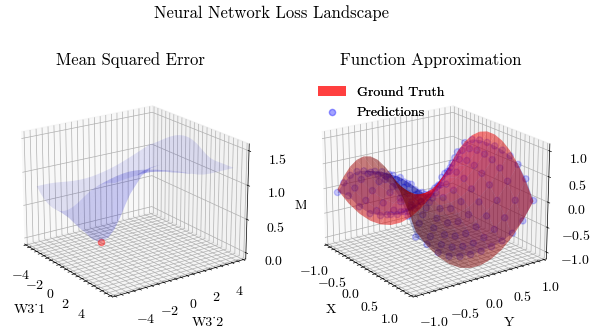

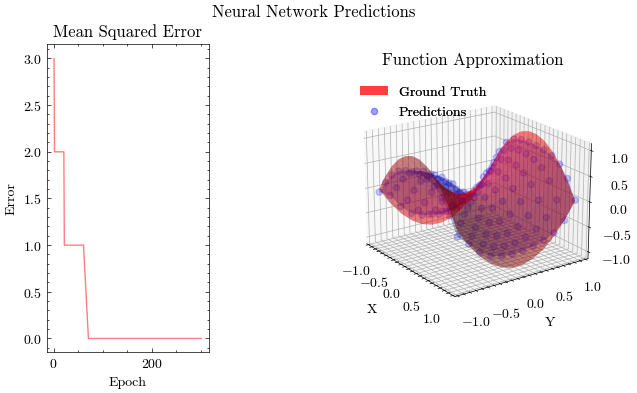

In [13]:
epochs = 301
learning_rate = 0.005
optimizer = GradientDescentOptimizier(learning_rate)

mse_plot_filename = "neural_network.gif"
loss_landscape_plot_filename = "neural_network_loss_landscape.gif"
fit(
    model,
    features,
    labels,
    X,
    Y,
    Z,
    dims,
    epochs,
    optimizer,
    mse_plot_filename,
    loss_landscape_plot_filename,
)

## Output GIF

In this visualization, we see the predictions fit the ground truth. The neural network was able to find the optimal parameters to fit this function. Now think about the applications of this. Given input data about people's shopping habits, we can predict things to recommend to them. We can recommend a social media post to show them or a show to watch next. We can pass data to neural networks and it will uncover patterns from input data and find patterns.

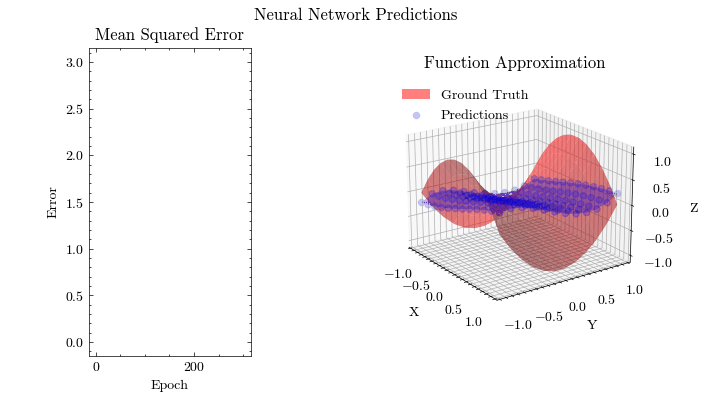

In [14]:
Image(filename=mse_plot_filename)

The visualization below shows that backpropagation finds the optimal weights for the neural network. On the left graph, the red dot shows the current values of the weight matrix in the last layer of the neural network. The z axis is the mean squared error loss. If the weights weren't at the current value, the loss wouldn't be at a minima, meaning that backpropagation in fact does update the weights to the most optimal (local extrema) value and allows the network to converge.

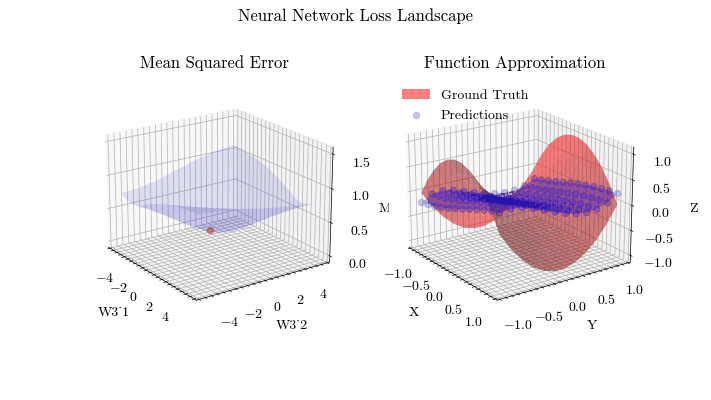

In [15]:
Image(filename=loss_landscape_plot_filename)

## Pytorch Implementation

Machine Learning libraries, such as PyTorch, provide utilities to easily train and test neural networks on all types of optimized hardware. Now we will implement the same network in PyTorch.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

## PyTorch nn.Module

We represent our neural network by creating a subclass of the `nn.Module` PyTorch class that defines all of the layers in the network and how data flows through the network. The `forward()` method is the forward propagation of our neural forward. Notice that we don't need to specify anything for the backpropagation process. PyTorch takes care of this for us using their auto-differentiation support. We just need to import an optimizer class, like the PyTorch provided gradient descent class, and pass in our model's parameters. This is the beauty of using machine learning libraries.

In [17]:
class TorchNet(nn.Module):
    def __init__(self):
        super(TorchNet, self).__init__()

        # define the layers
        self.fc1 = nn.Linear(2, 14)
        self.fc2 = nn.Linear(14, 2)
        self.fc3 = nn.Linear(2, 1)

    def forward(self, x):
        # pass the result of the previous layer to the next layer
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return F.tanh(self.fc3(x))

## PyTorch Training

Similar to our own implementation, let's use our model to define our training process. In each epoch, we will do the following:

1. Pass the training data into our model to get the model's predictions
2. Calculate the loss from the model's predictions and the expected value
3. Use the loss to run the optimizer to update the weights and biases
4. Call the visualization functions to visualize the training process

In [18]:
def torch_fit(
    model, features, labels, X, Y, Z, dims, epochs, optimizer, output_filename
):
    mse_idx = np.arange(1, epochs + 1)
    errors = np.full(epochs, -1)
    mse_ax, predictions_ax1, camera1 = create_scatter_and_3d_plot()

    loss_fn = nn.MSELoss()

    for idx in range(epochs):
        error = 0
        predictions = np.array([])

        for x, y in zip(features, labels):
            # Forward Propagation
            output = model(x)

            output_np = output.detach().cpu().numpy()
            predictions = np.append(predictions, output_np)

            # Store Error
            loss = loss_fn(output, y)

            error += loss.detach().cpu().numpy()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        error /= len(X)

        if show_epoch(idx):
            print(f"epoch: {idx}, MSE: {error}")

            # Plot MSE
            errors[idx] = error
            visible_mse = errors != -1

            plot_mse_and_predictions(
                mse_ax,
                predictions_ax1,
                idx,
                visible_mse,
                mse_idx,
                errors,
                X,
                Y,
                Z,
                predictions,
                dims,
            )

            camera1.snap()

    animation1 = camera1.animate()
    animation1.save(output_filename, writer="pillow")
    plt.show()

Let's call the training method and pass in the model, training data, and optimizer.

epoch: 0, MSE: 2.984565019607544
epoch: 1, MSE: 2.7075679302215576
epoch: 2, MSE: 2.6843478679656982
epoch: 3, MSE: 2.6776466369628906
epoch: 4, MSE: 2.681764841079712
epoch: 5, MSE: 2.690561294555664
epoch: 6, MSE: 2.700050115585327
epoch: 7, MSE: 2.7078511714935303
epoch: 8, MSE: 2.7127301692962646
epoch: 9, MSE: 2.7142038345336914
epoch: 10, MSE: 2.712219476699829
epoch: 11, MSE: 2.7069084644317627
epoch: 12, MSE: 2.698435068130493
epoch: 13, MSE: 2.686903715133667
epoch: 14, MSE: 2.672306776046753
epoch: 15, MSE: 2.654496908187866
epoch: 16, MSE: 2.6331663131713867
epoch: 17, MSE: 2.607834577560425
epoch: 18, MSE: 2.5778284072875977
epoch: 19, MSE: 2.5422799587249756
epoch: 20, MSE: 2.500131607055664
epoch: 21, MSE: 2.4501821994781494
epoch: 22, MSE: 2.3912034034729004
epoch: 23, MSE: 2.322108507156372
epoch: 24, MSE: 2.242227554321289
epoch: 25, MSE: 2.151536703109741
epoch: 30, MSE: 1.5780051946640015
epoch: 40, MSE: 0.4502718448638916
epoch: 50, MSE: 0.15558312833309174
epoch: 6

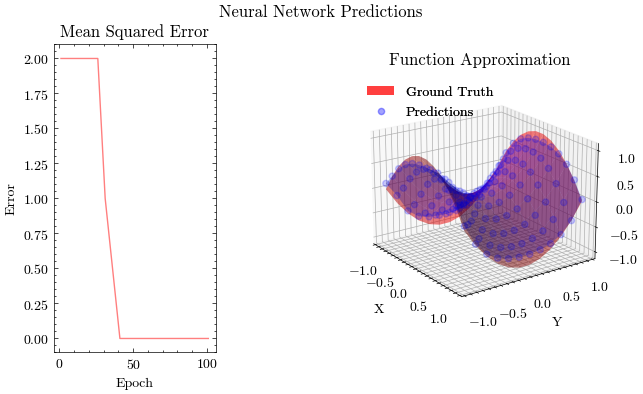

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch_model = TorchNet().to(device)

# the inputs and outputs for PyTorch must be tensors
features_tensor = torch.tensor(features, device=device, dtype=torch.float32).squeeze(-1)
labels_tensor = torch.tensor(labels, device=device, dtype=torch.float32).squeeze(-1)

epochs = 101
learning_rate = 0.005
optimizer = torch.optim.SGD(torch_model.parameters(), lr=learning_rate, momentum=0.0)

output_filename_pytorch = "neural_network_pytorch.gif"
torch_fit(
    torch_model,
    features_tensor,
    labels_tensor,
    X,
    Y,
    Z,
    dims,
    epochs,
    optimizer,
    output_filename_pytorch,
)

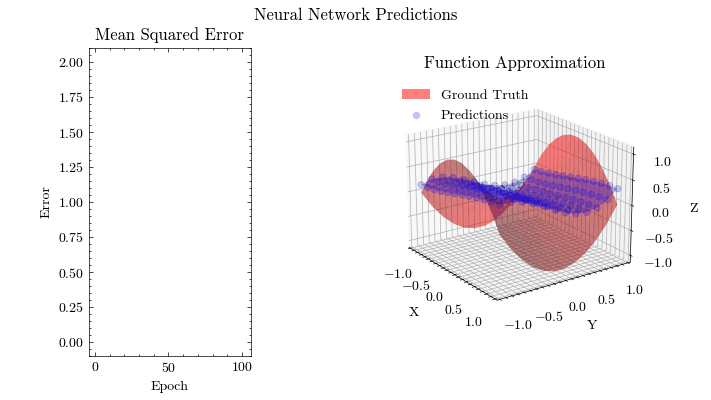

In [20]:
Image(filename=output_filename_pytorch)